<a href="https://colab.research.google.com/github/sumitsomans/EigenSample/blob/beta/EigenSample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy import optimize
from sklearn.svm import SVC
from sklearn.utils import resample
from numpy import linalg as LA
from sklearn.model_selection import train_test_split

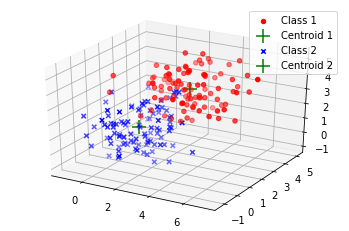

Cluster 1 center [2.74042969 3.0234081  3.12781552]
Cluster 2 center [1.10396047 1.21327163 1.06768791]


In [126]:
# create synthetic dataset in three dimensions and generate plot

c1_mean = [3,3,3]
c1_cov = [[2, 0, 0], [0, 1, 0], [0, 0, 1]]
clust1=np.random.multivariate_normal(c1_mean, c1_cov, 100)
centroid1=clust1.mean(0)
c1_samples=clust1.shape[0]

c2_mean = [1,1,1]
c2_cov = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
clust2=np.random.multivariate_normal(c2_mean, c2_cov, 100)
centroid2=clust2.mean(0)
c2_samples=clust2.shape[0]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
s1=ax.scatter(clust1[:,0],clust1[:,1],clust1[:,2], c='r', marker='o')
s2=ax.scatter(centroid1[0],centroid1[1],centroid1[2], s=200,  c='g', marker='+')
s3=ax.scatter(clust2[:,0],clust2[:,1],clust2[:,2], c='b', marker='x')
s4=ax.scatter(centroid2[0],centroid2[1],centroid2[2], s=200, c='g', marker='+')
ax.legend((s1,s2,s3,s4),('Class 1','Centroid 1','Class 2','Centroid 2'))
plt.show()

print('Cluster 1 center', centroid1)
print('Cluster 2 center', centroid2)

Singular Values [19.3283353  11.62077466]
Variance Explained [0.62264091 0.22507067]


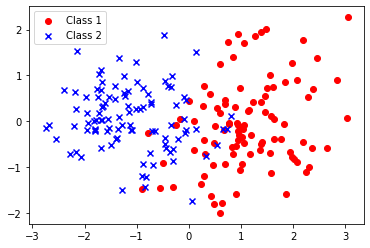

In [141]:
# Create dataset
X=np.concatenate((clust1, clust2), axis=0)

##  Scale dataset - if needed
X = StandardScaler().fit_transform(X)

X_mean=np.mean(X,axis=0)

# Train SVM on data
trainData=X
trainLabels=np.concatenate([np.zeros(c1_samples),np.ones(c2_samples)])
clf = SVC(kernel='rbf') 
clf.fit(trainData, trainLabels) 

# Perform PCA of data and visualize projections to first two components
n_components_=2
pca = PCA(n_components=n_components_)
pca.fit(X)
principalComponents=pca.transform(X)
print('Singular Values', pca.singular_values_)
print('Variance Explained', pca.explained_variance_ratio_)


fig = plt.figure()
ax = fig.add_subplot(111)
s1=ax.scatter(principalComponents[:c1_samples-1,0], principalComponents[:c1_samples-1,1], c='r', marker='o')
s2=ax.scatter(principalComponents[c1_samples:,0], principalComponents[c1_samples:,1], c='b', marker='x')
ax.legend((s1,s2),('Class 1','Class 2'))
plt.show()

k-means cluster centers [[-1.17776166  0.04034523]
 [ 1.17776166 -0.04034523]]


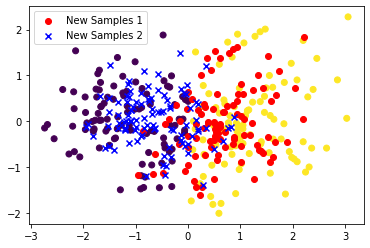

In [142]:
# Cluster dataset using k means and add new points
kmeans = KMeans(n_clusters=2, random_state=0).fit(principalComponents)
print('k-means cluster centers',kmeans.cluster_centers_)

# add new points - as an example points have been added in the ratio 0.8:0.2
new_points_1=(0.8*principalComponents[:c1_samples-1,]+0.2*kmeans.cluster_centers_[0,:])
new_points_2=(0.8*principalComponents[c1_samples:,]+0.2*kmeans.cluster_centers_[1,:])

fig=plt.figure()
ax = fig.add_subplot(111)
s1=ax.scatter(principalComponents[:,0], principalComponents[:,1], c=kmeans.labels_.astype(float))
s2=ax.scatter(new_points_1[:,0],new_points_1[:,1], c='r', marker='o')
s3=ax.scatter(new_points_2[:,0],new_points_2[:,1], c='b', marker='x')
ax.legend((s2,s3),('New Samples 1','New Samples 2'))
plt.show()


In [0]:
# Define QP solver with bounds
class quadprog(object):

    def __init__(self, H, f, A, b, x0, lb, ub):
        self.H    = H
        self.f    = f
        self.A    = A
        self.b    = b
        self.x0   = x0
        #self.bnds = tuple([(lb, ub) for x in x0])
        self.bnds = tuple(list(zip(lb,ub)))
        # call solver
        self.result = self.solver()

    def objective_function(self, x):
        return 0.5*np.dot(np.dot(x.T, self.H), x) + np.dot(self.f.T, x)

    def solver(self):
        cons = ({'type': 'ineq', 'fun': lambda x: self.b - np.dot(self.A, x)})
        optimum = optimize.minimize(self.objective_function, 
                                    x0          = self.x0.T,
                                    bounds      = self.bnds,
                                    constraints = cons, 
                                    tol         = 10**-3)
        return optimum

In [144]:
# Compute reverse projection for samples by solving QPP

# Dataset size variables
N=X.shape[1]
K=principalComponents.shape[1]
G=pca.components_
new_dataset=np.empty((0,N),float)

# Define hyperparameters
Cparam=0.01
epsParam=0.001

# Initialization
x0=np.concatenate([np.random.rand(N,), np.random.rand(K,), np.random.rand(K,)])
#print('x0',x0.shape)

# Setup linear terms for quadprog
f=np.concatenate([np.zeros(N,), Cparam*np.ones(K,), Cparam*np.ones(K,)]).T # [z, q+, q-]
#print('f',f.shape)


# Setup quadratic term for quadprog
H1=np.concatenate((np.identity(N), np.zeros((N,K)), np.zeros((N,K))), 1)
H2=np.concatenate((np.zeros((K,N)), np.zeros((K,K)), np.zeros((K,K))), 1)
H=np.concatenate((H1,H2,H2), axis=0)
#print('H',H.shape) 

# Set lower and upper bounds for solver
lb=np.concatenate((X.min(0),np.zeros(K),np.zeros(K)),axis=0)
ub=np.concatenate((X.max(0),np.ones(K) * np.inf,np.ones(K) * np.inf),axis=0)
# print(lb,ub)

# Setup linear constraints of Ax<=b
A1=np.concatenate((G, np.identity(K), np.zeros((K,K))), 1) # Gz - q+ <= x + eps
A2=np.concatenate((-G, np.zeros((K,K)), -np.identity(K)), 1) # -Gz - q- <= -x + eps
A_ineq = np.concatenate((A1,A2), axis=0)
#print('A_ineq',A_ineq.shape)


# iterate over each sample and generate new sample by solving QPP

for i in range(X.shape[0]):
  sample=principalComponents[i,]
  eps_vector=np.squeeze(epsParam*np.ones((K,1)))
  b_ineq=np.concatenate((sample+eps_vector, -sample+eps_vector),0).T
  #print('b_ineq',b_ineq.shape)

  # call custom quadprog
  X_sol  = quadprog(H, f, A_ineq, b_ineq, x0, lb, ub)
  new_sample = X_sol.result.x[:N] + X_mean
  #print(new_sample)
  new_dataset=np.vstack([new_dataset,new_sample])
  

print('Generated new dataset of size: ',new_dataset.shape)

Generated new dataset of size:  (200, 3)


In [145]:
# compute labels of new points
new_labels=clf.predict(new_dataset)
print('Computed labels', new_labels)


Computed labels [0. 1. 1. 1. 0. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 1. 1.
 0. 1. 0. 1. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1.]


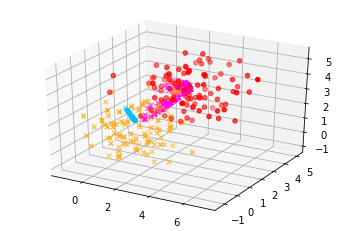

Cluster 1 center [2.74042969 3.0234081  3.12781552]
Cluster 2 center [1.10396047 1.21327163 1.06768791]
New Cluster 1 center [2.26705472 2.80940243 2.8048126 ]
New Cluster 2 center [1.81909043 2.19093094 2.15779659]
Norm of Diff in cluster centers 0.6117296569751336 1.6295906006510246


In [147]:
# # rescale points by mean
# for i in range(new_dataset.shape[0]):
#   if new_labels[i]==1:
#     new_dataset[i,]=new_dataset[i,]+X1_mean
#   else:
#     new_dataset[i,]=new_dataset[i,]+X2_mean


#compute new cluster centers and plot new data

clust1_new=new_dataset[new_labels==0,]
clust2_new=new_dataset[new_labels==1,]


c1_new=clust1_new.mean(0)
c2_new=clust2_new.mean(0)


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
s1=ax.scatter(clust1[:,0],clust1[:,1],clust1[:,2], c='red', marker='o')
s2=ax.scatter(clust2[:,0],clust2[:,1],clust2[:,2], c='orange', marker='x')
s3=ax.scatter(clust1_new[:,0],clust1_new[:,1],clust1_new[:,2], c='deepskyblue', marker='o')
s4=ax.scatter(clust2_new[:,0],clust2_new[:,1],clust2_new[:,2], c='magenta', marker='x')

plt.show()

print('Cluster 1 center', centroid1)
print('Cluster 2 center', centroid2)

# compute new cluster means
clust1_full=np.concatenate((clust1,clust1_new),axis=0)
clust2_full=np.concatenate((clust2,clust2_new),axis=0)
c1_full_new=clust1_full.mean(0)
c2_full_new=clust2_full.mean(0)

print('New Cluster 1 center', c1_full_new)
print('New Cluster 2 center', c2_full_new)

diff_c1_es=LA.norm(centroid1-c1_full_new)
diff_c2_es=LA.norm(centroid2-c2_full_new)

print('Norm of Diff in cluster centers',diff_c1_es,diff_c2_es)

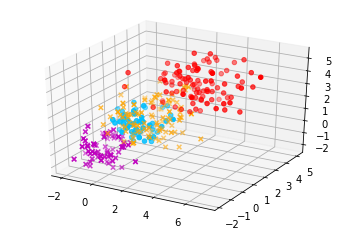

New Cluster 1 center [1.69324624 1.81460193 1.95147464]
New Cluster 2 center [0.25757951 0.27300154 0.09968962]
Norm of Diff in cluster centers 1.9853421396542619 1.5929498599736787


In [148]:
# Compare with bootstrapping

X_resample=resample(X)
new_labels_rs=clf.predict(X_resample)

clust1_resample=X_resample[new_labels_rs==0,]
clust2_resample=X_resample[new_labels_rs==1,]


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
s1=ax.scatter(clust1[:,0],clust1[:,1],clust1[:,2], c='red', marker='o')
s2=ax.scatter(clust2[:,0],clust2[:,1],clust2[:,2], c='orange', marker='x')
s3=ax.scatter(clust1_resample[:,0],clust1_resample[:,1],clust1_resample[:,2], c='deepskyblue', marker='o')
s4=ax.scatter(clust2_resample[:,0],clust2_resample[:,1],clust2_resample[:,2], c='m', marker='x')

plt.show()

# compute new cluster means
clust1_full_rs=np.concatenate((clust1,clust1_resample),axis=0)
clust2_full_rs=np.concatenate((clust2,clust2_resample),axis=0)
c1_full_rs=clust1_full_rs.mean(0)
c2_full_rs=clust2_full_rs.mean(0)

print('New Cluster 1 center', c1_full_rs)
print('New Cluster 2 center', c2_full_rs)

diff_c1_rs=LA.norm(centroid1-c1_full_rs)
diff_c2_rs=LA.norm(centroid2-c2_full_rs)

print('Norm of Diff in cluster centers',diff_c1_rs,diff_c2_rs)

In [149]:
# compare classification accuracies 

# original dataset
X_train, X_test, y_train, y_test = train_test_split(trainData, trainLabels, test_size=0.2, random_state=0)
clf = SVC(kernel='rbf').fit(X_train, y_train)
orig_acc=clf.score(X_test, y_test)
print('Original Dataset Accuracy',orig_acc)

# augmented dataset
trainDataAug=np.concatenate((trainData,new_dataset),axis=0)
trainLabelsAug=np.concatenate((trainLabels,new_labels),axis=0)
X_train, X_test, y_train, y_test = train_test_split(trainDataAug, trainLabelsAug, test_size=0.2, random_state=0)
clf = SVC(kernel='rbf').fit(X_train, y_train)
es_aug_acc=clf.score(X_test, y_test)
print('Eigensample augmented accuracy',es_aug_acc)

# bootstrapped dataset
trainDataBS=np.concatenate((trainData,X_resample),axis=0)
trainLabelsBS=np.concatenate((trainLabels,new_labels_rs),axis=0)
X_train, X_test, y_train, y_test = train_test_split(trainDataBS, trainLabelsBS, test_size=0.2, random_state=0)
clf = SVC(kernel='rbf').fit(X_train, y_train)
bs_aug_acc=clf.score(X_test, y_test)
print('Bootstrapping augmented accuracy',bs_aug_acc)

Original Dataset Accuracy 0.925
Eigensample augmented accuracy 0.9125
Bootstrapping augmented accuracy 0.9375
